In [1]:
%cd ~/team/gj/code

/opt/ml/team/gj/code


# Distribution

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import pickle
import yaml

from dataset import split_gt, load_sources, load_levels

plt.style.use('dark_background')

In [3]:
options = yaml.safe_load(open('/opt/ml/team/gj/code/configs/Default.yaml', 'r'))
sources = load_sources(options['data']['source_paths'])
levels = load_sources(options['data']['level_paths'])

In [4]:
source_to_name = {
    0: '출력물',
    1: '프린트',
}

level_to_name = {
    1: '초등',
    2: '중등',
    3: '고등',
    4: '대학',
    5: '대학 이상',
}

In [5]:
!ls /opt/ml/input/data/saving_model

log			  satrn_curr		       satrn_new_baseline_test
satrn			  satrn_curr_diff_lrs	       satrn_reverse
satrn_adaptive_2d	  satrn_curr_longer_test       satrn_stn
satrn_adaptive_locality   satrn_extra_pb	       satrn_stn_test
satrn_basic		  satrn_flex_local_aware_long  satrn_test
satrn_criterion		  satrn_flexible_size	       satrn_tf_scheduler
satrn_criterion_test	  satrn_locality_aware	       satrn_tube
satrn_cur_best_long	  satrn_model_save	       satrn_tube_enc
satrn_cur_best_long_test  satrn_new_baseline	       satrn_tube_test


In [6]:
import torch
from checkpoint import load_checkpoint
from flags import Flags
import random
from torchvision import transforms
import utils
from utils import get_network
from dataset import LoadDataset, SizeBatchSampler, collate_batch, PAD
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train_method import id_to_string

from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

In [7]:
checkpoint_name = "/opt/ml/input/data/saving_model/satrn_test/checkpoints/best.pth"

In [8]:
is_cuda = torch.cuda.is_available()
checkpoint = load_checkpoint(checkpoint_name, cuda=is_cuda)
checkpoint['configs']['SATRN']['flexible_stn']['train_stn_only'] = False
options, _ = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
def get_dataset(paths):
    data = []
    for i, path in enumerate(paths):
        data_from_file = split_gt(path)
        data += data_from_file
        print(f'From {path}')
        print(f'Val +:\t{len(data_from_file)}')
    return data

dataset = get_dataset(options.data.test)
len(dataset)

From /opt/ml/input/data/train_dataset/test_gt_s:0_l:1.txt
Val +:	750
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:2.txt
Val +:	6458
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:3.txt
Val +:	1847
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:4.txt
Val +:	831
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:5.txt
Val +:	114
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:1.txt
Val +:	1951
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:2.txt
Val +:	2248
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:3.txt
Val +:	4910
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:4.txt
Val +:	891


20000

In [11]:
hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)
print("--------------------------------")
print("Running {} on device {}\n".format(options.network, device))

model_checkpoint = checkpoint["model"]
if model_checkpoint:
    print(
        "[+] Checkpoint\n",
        "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
    )


if options.data.flexible_image_size:
    transformed = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
else:
    transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )

# random.shuffle(wrong_data)
# random.shuffle(correct_data)
# data = wrong_data[:1]
# data = correct_data[:1]
data = [
    ['/opt/ml/input/data/train_dataset/images/train_44558.jpg', 'a _ { \\theta } = r \\ddot \\theta + 2 \\dot r \\dot \\theta = \\left( 0 . 7 5 m + 0 . 5 m \\right) \\times \\ddot \\theta + 2 \\times 0 . 2 m / s']
]
valid_dataset = LoadDataset(
    data, options.data.token_paths, sources=sources,
    levels=levels, crop=options.data.crop,
    transform=transformed, rgb=options.data.rgb,
    max_resolution=options.input_size.height * options.input_size.width,
    is_flexible=options.data.flexible_image_size,
    is_reverse=options.data.is_reverse,
)

valid_sampler = SizeBatchSampler(valid_dataset, 36, is_random=True)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_sampler=valid_sampler,
    num_workers=4,
    collate_fn=collate_batch,
)

--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 60



  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
model = get_network(
    options.network,
    options,
    model_checkpoint,
    device,
    valid_dataset,
)
model.eval()
print()

RuntimeError: Error(s) in loading state_dict for SATRN:
	size mismatch for stn.middle.6.weight: copying a param with shape torch.Size([4, 256]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for stn.middle.6.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).

In [13]:
train = False
data_loader = valid_data_loader
use_amp=options.use_amp and device.type == 'cuda'
epoch_text = ''
teacher_forcing_ratio = 0

correct = []
wrong = []
    
# Disables autograd during validation mode
torch.set_grad_enabled(False)

model.eval()

idx = 0
with tqdm(
    desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
    total=len(data_loader.dataset),
    dynamic_ncols=True,
    leave=False,
) as pbar:
    for d in data_loader:
        input = d["image"].to(device)

        # The last batch may not be a full batch
        curr_batch_size = len(input)
        expected = d["truth"]["encoded"].to(device)
        levels_expected = d['level'].to(device)
        sources_expected = d['source'].to(device)

        # Replace -1 with the PAD token
        expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

        with autocast(enabled=use_amp):
            outputs_dict= model(input, expected, train, teacher_forcing_ratio, 
                        return_attn=True, return_stn=True)
            output = outputs_dict['out']
            decoded_values = output.transpose(1, 2)
            _, sequence = torch.topk(decoded_values, 1, dim=1)
            sequence = sequence.squeeze(1)

        pbar.update(curr_batch_size)

        expected = id_to_string(expected, data_loader, do_eval=1)
        sequence = id_to_string(sequence, data_loader, do_eval=1)
        break
        for i in range(curr_batch_size):
            id = int(d['path'][i].split('/')[-1].split('_')[1].split('.')[0])
            ex = expected[i]
            sq = sequence[i]
            same = ex == sq
            path = d['path'][i]
            image = d['image'][i]
            level = d['level'][i]
            source = d['source'][i]
            ex_len = len(ex.split())
            pred_len = len(sq.split())
            
            cur_item = {
                'id': id,
                'correct': same,
                'expected': ex,
                'sequence': sq,
                'level': level,
                'source': source,
                'path': path,
                'ex_len': ex_len,
                'pred_len': pred_len,
            }
            
            if same:
                correct.append(cur_item)
            else:
                wrong.append(cur_item)
    
print('done')

 (Validation):   0%|          | 0/1 [00:00<?, ?it/s]

done


In [21]:
which = outputs_dict['which']
which

In [25]:
input.shape

torch.Size([1, 1, 512, 32])

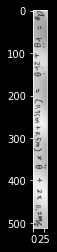

In [111]:
idx = 0
img = outputs_dict['stn'][idx].squeeze(0).cpu().numpy()
img = (img* 256).astype(int)
plt.imshow(img, cmap='gray')

5


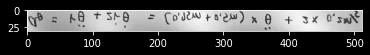

In [112]:
print(which)
img = new_input[idx].squeeze(0).cpu().numpy()
img = (img* 256).astype(int)
plt.imshow(img, cmap='gray')
# idx += 1

In [43]:
idx = 0

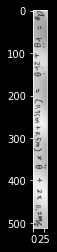

In [44]:
img = input[idx].squeeze(0).cpu().numpy()
img = (img* 256).astype(int)
plt.imshow(img, cmap='gray')

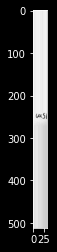

In [45]:
img = outputs_dict['stn'][idx].squeeze(0)
img = (img* 256).astype(int)
plt.imshow(img, cmap='gray')
idx += 1

In [ ]:
# saving = {
#     'correct': correct,
#     'wrong': wrong,
# }

# save_root = '/opt/ml/team/gj/notebooks/save'
# name = checkpoint_name.split('/')[-3]

# save_name = f'{save_root}/{name}'

# pickle.dump(saving, open(save_name, 'wb'))

In [ ]:
!ls /opt/ml/team/gj/notebooks/save

In [ ]:
normal = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_criterion', 'rb'))
rev = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_reverse', 'rb'))
best = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_cur_best_long', 'rb'))

In [ ]:
normal_dict = {x['id']: x for x in normal['wrong'] + normal['correct']}
rev_dict = {x['id']: x for x in rev['wrong'] + rev['correct']}
best_dict = {x['id']: x for x in best['wrong'] + best['correct']}

In [ ]:
normal_wrong_ids = set(x['id'] for x in normal['wrong'])
rev_wrong_ids = set(x['id'] for x in rev['wrong'])
best_wrong_ids = set(x['id'] for x in best['wrong'])

In [ ]:
import torch
from checkpoint import load_checkpoint
from flags import Flags
import random
from torchvision import transforms
import utils
from utils import get_network
from dataset import LoadDataset, SizeBatchSampler, collate_batch, PAD
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train_method import id_to_string

from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

In [ ]:
checkpoint = "/opt/ml/input/data/saving_model/satrn_cur_best_long/checkpoints/best.pth"

In [ ]:
is_cuda = torch.cuda.is_available()
checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
options, _ = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def show_heatmap(data, checkpoint, layer=2):
    is_cuda = torch.cuda.is_available()
    checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
    options, _ = Flags(checkpoint["configs"]).get()
    torch.manual_seed(options.seed)
    random.seed(options.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    hardware = "cuda" if is_cuda else "cpu"
    device = torch.device(hardware)
    print("--------------------------------")
    print("Running {} on device {}\n".format(options.network, device))

    model_checkpoint = checkpoint["model"]
    if model_checkpoint:
        print(
            "[+] Checkpoint\n",
            "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
        )


    if options.data.flexible_image_size:
        transformed = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    else:
        transformed = transforms.Compose(
            [
                transforms.Resize((options.input_size.height, options.input_size.width)),
                transforms.ToTensor(),
            ]
        )
    
    valid_dataset = LoadDataset(
        data, options.data.token_paths, sources=sources,
        levels=levels, crop=options.data.crop,
        transform=transformed, rgb=options.data.rgb,
        max_resolution=options.input_size.height * options.input_size.width,
        is_flexible=options.data.flexible_image_size,
        is_reverse=options.data.is_reverse,
    )

    valid_sampler = SizeBatchSampler(valid_dataset, 16, is_random=True)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_sampler=valid_sampler,
        num_workers=0,
        collate_fn=collate_batch,
    )
    
    model = get_network(
        options.network,
        options,
        model_checkpoint,
        device,
        valid_dataset,
    )
    model.eval()
    
    train = False
    data_loader = valid_data_loader
    use_amp=options.use_amp and device.type == 'cuda'
    epoch_text = ''
    teacher_forcing_ratio = 0

    # Disables autograd during validation mode
    torch.set_grad_enabled(False)

    model.eval()

    with tqdm(
        desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
        total=len(data_loader.dataset),
        dynamic_ncols=True,
        leave=False,
    ) as pbar:
        for d in data_loader:
            input = d["image"].to(device)

            # The last batch may not be a full batch
            curr_batch_size = len(input)
            expected = d["truth"]["encoded"].to(device)
            levels_expected = d['level'].to(device)
            sources_expected = d['source'].to(device)

            # Replace -1 with the PAD token
            expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

            with autocast(enabled=use_amp):
                outputs_dict= model(input, expected, train, teacher_forcing_ratio, return_attn=True)
                output = outputs_dict['out']
                decoded_values = output.transpose(1, 2)
                _, sequence = torch.topk(decoded_values, 1, dim=1)
                sequence = sequence.squeeze(1)

            pbar.update(curr_batch_size)

    expected = id_to_string(expected, data_loader)
    sequence = id_to_string(sequence, data_loader)
    
    cur_idx = 0
    o = outputs_dict['out'][cur_idx]
    er = outputs_dict['enc_result'][cur_idx]
    at1 = outputs_dict['attns_1']
    at2 = outputs_dict['attns_2']
    im = d['image'][cur_idx]
    ex = expected[cur_idx]
    se = sequence[cur_idx]

    h, w, _ = er.shape
    cat1 = [x.squeeze(0).squeeze(1) for x in at1]
    cat2 = [x.squeeze(0).squeeze(1).reshape(-1, h, w).sum(0) for x in at2]
    
    print(f'Expected: {ex[6:]}')
    print(f'Sequence: {se}')
    
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(im.squeeze(0), cmap='gray')
    plt.show()
    
    ser = er.sum(-1)
    ser = (ser - ser.min()) / (ser.max() - ser.min())
    ser = ser.repeat(8, 0).repeat(8, 1)

    fig = plt.figure(figsize=(20, 20))
    plt.imshow(im.squeeze(0), cmap='gray')
    plt.imshow(ser, alpha=0.8, cmap='Reds')
    plt.show()
    
    latex = ['[BOS]'] + se.split()
    for idx in range(len(latex)-1):
        st = idx

        fig = plt.figure(figsize=(20, 10))
        plt.imshow(im.squeeze(0), cmap='gray')

        j = 3 * st + layer
        ser = (er * cat2[j][:, :, None])
        ser = ser.sum(-1)
        ser = (ser - ser.min()) / (ser.max() - ser.min())
        ser = ser.repeat(8, 0).repeat(8, 1)

        plt.imshow(ser, alpha=0.8, cmap='Reds')

        if idx + 1 < len(latex):
            next_c = latex[idx + 1]
        else:
            next_c = 'FIN'

        plt.title(f'{latex[idx]} -> {next_c}', size='x-large')
        plt.show()
        print()
    



In [ ]:
idx = 0

In [ ]:
idx -= 1

In [ ]:

cur_item = best['wrong'][idx]
data = [
    [cur_item['path'], cur_item['expected']],
]
layer = 2

# checkpoint = "/opt/ml/input/data/saving_model/satrn_reverse/checkpoints/0010.pth"
# checkpoint = "/opt/ml/input/data/saving_model/satrn_criterion/checkpoints/best.pth"
checkpoint = "/opt/ml/input/data/saving_model/satrn_cur_best_long/checkpoints/best.pth"
show_heatmap(data, checkpoint, layer=layer)
idx += 1

In [ ]:
a = normal['wrong'][0]

In [ ]:
a['expected']

In [ ]:
check = []
for a in normal['wrong']:
    half_len = a['pred_len'] // 2
    exp_half = ' '.join(a['expected'].split()[:half_len])
    seq_half = ' '.join(a['sequence'].split()[:half_len])

    if exp_half == seq_half and a['ex_len'] <= 10:
        check.append(a)

In [ ]:
len(check)

In [ ]:
gt_txt = '/opt/ml/input/data/train_dataset/gt.txt'
gt_s = split_gt(gt_txt)

In [ ]:
for found in gt_s:
#     if found[1] == '5 \times 1 1 = 5 5':
    if '25502' in found[0]:
        print('found')
        break
found

In [ ]:
idx = 0

In [ ]:
idx -= 1

In [ ]:
# idx = 9
# data = [
#     [check[idx]['path'], check[idx]['expected']],
# ]
data = [
    found
]

# checkpoint = "/opt/ml/input/data/saving_model/satrn_reverse/checkpoints/0010.pth"
checkpoint = "/opt/ml/input/data/saving_model/satrn_criterion/checkpoints/best.pth"

print(idx)
show_heatmap(data, checkpoint)
idx += 1
